#Ticket Yoda - Feature importance

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import io
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1bcu2TSWXPFedsnmQV2BppNpnMU6YC6Qv' # The id File
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('FINAL_MASTER.csv')  
df = pd.read_csv('FINAL_MASTER.csv')


In [0]:
df.head()

,artist,date,weekday,promoter,SG_venue,venue_city,venue_state,TM_max,SG_max_price,TM_min,...,daystoconcert,segment,genre,subGenre,Capture_date,SG_listing_count,SG_venue_score,max_pop,max_follow,SG_artists_score
0,Lake Street Dive,1/15/2019,Tuesday,PROMOTED BY VENUE,Ponte Vedra Concert Hall,Ponte Vedra Beach,FL,34.5,36.0,34.5,...,0,Music,Rock,Alternative Rock,1/15/2019,3,0.466979,64,191086,0.56
1,Mineral,1/16/2019,Wednesday,LIVE NATION MUSIC,Theatre of Living Arts,Philadelphia,PA,25.0,109.0,25.0,...,1,Music,Rock,Alternative Rock,1/15/2019,35,0.503499,41,19707,0.39
2,Mineral,1/16/2019,Wednesday,LIVE NATION MUSIC,Theatre of Living Arts,Philadelphia,PA,25.0,68.0,25.0,...,0,Music,Rock,Alternative Rock,1/16/2019,5,0.503499,41,19746,0.39
3,Dylan Scott,1/17/2019,Thursday,LIVE NATION MUSIC,Gramercy Theatre,New York,NY,50.5,286.0,30.5,...,2,Music,Country,Country,1/15/2019,14,0.515187,66,372825,0.49
4,Vertical Horizon,1/17/2019,Thursday,PROMOTED BY VENUE,Highline Ballroom,New York,NY,75.0,217.0,35.0,...,2,Music,Rock,Alternative Rock,1/15/2019,10,0.506355,56,184769,0.42


#Data cleaning

In [0]:
##Removing rows accordingly to our data cleaning process
#Remove max popularity < 10
#Remove max followers <10
#Remove data points with average price > 400 (IQR 0.75 - 0.25 + Mean)
#Drop any lines with NA, None
#Remove venue score 0 and artist score 0

df = df[df['SG_average_price'] > 0]

df=df[df['SG_average_price'] <= 400]

df=df[df['max_pop'] >=10]

df=df[df['max_follow'] >=10]

df=df[df['SG_venue_score'] >=0.1]

df=df[df['SG_artists_score'] >=0.1]



In [0]:
#drop NAs
df.isna().sum()
df= df.dropna()
df.isna().sum()


artist              0
date                0
weekday             0
promoter            0
SG_venue            0
venue_city          0
venue_state         0
TM_max              0
SG_max_price        0
TM_min              0
SG_min_price        0
SG_average_price    0
daystoconcert       0
segment             0
genre               0
subGenre            0
Capture_date        0
SG_listing_count    0
SG_venue_score      0
max_pop             0
max_follow          0
SG_artists_score    0
dtype: int64

In [0]:
df.shape

(11861, 22)

In [0]:
#Change to numeric

df["SG_artists_score"] = pd.to_numeric(df["SG_artists_score"])
df["SG_venue_score"] = pd.to_numeric(df["SG_venue_score"])
df["max_pop"] = pd.to_numeric(df["max_pop"])
df["max_follow"] = pd.to_numeric(df["max_follow"])
df["daystoconcert"] = pd.to_numeric(df["daystoconcert"])
df["SG_average_price"] = pd.to_numeric(df["SG_average_price"])

#Change text object to String

df[["promoter", "genre","subGenre","venue_city","venue_state","SG_venue","weekday"]] = df[["promoter", "genre","subGenre","venue_city","venue_state", "SG_venue","weekday"]].astype(str) 


#Coerce string to categories
df["promoter"] = df["promoter"].astype('category')
df["genre"] = df["genre"].astype('category')
df["subGenre"] = df["subGenre"].astype('category')
df["venue_city"] = df["venue_city"].astype('category')
df["venue_state"] = df["venue_state"].astype('category')
df["weekday"] = df["weekday"].astype('category')
df["SG_venue"] = df["SG_venue"].astype('category')


In [0]:
df.dtypes

artist                object
date                  object
weekday             category
promoter            category
SG_venue            category
venue_city          category
venue_state         category
TM_max               float64
SG_max_price         float64
TM_min               float64
SG_min_price         float64
SG_average_price     float64
daystoconcert          int64
segment               object
genre               category
subGenre            category
Capture_date          object
SG_listing_count       int64
SG_venue_score       float64
max_pop                int64
max_follow             int64
SG_artists_score     float64
dtype: object

In [0]:
#from google.colab import files
#df.to_csv('df.csv')
#files.download('df.csv')

end of basic data cleaning

---



#OLS Model

In [0]:
#import libraries for modeling
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [0]:
#Removing target column from ORIGINAL DF

##Data
#Output is Type pandas df
X = df[['SG_artists_score',
'venue_city',
'SG_venue_score',
'venue_state',
'max_pop',
'max_follow',
'daystoconcert',
        "genre",
       "weekday"]]

#Target
#Output is Type pandas df
Y = df[['SG_average_price']].astype(int)



In [0]:
X.head()

,SG_artists_score,venue_city,SG_venue_score,venue_state,max_pop,max_follow,daystoconcert,genre,weekday
0,0.56,Ponte Vedra Beach,0.466979,FL,64,191086,0,Rock,Tuesday
1,0.39,Philadelphia,0.503499,PA,41,19707,1,Rock,Wednesday
2,0.39,Philadelphia,0.503499,PA,41,19746,0,Rock,Wednesday
3,0.49,New York,0.515187,NY,66,372825,2,Country,Thursday
4,0.42,New York,0.506355,NY,56,184769,2,Rock,Thursday


In [0]:
#One Hot! 


dummies1 = pd.get_dummies(df['promoter'])
X= pd.concat([X,dummies1],axis=1)

dummies2 = pd.get_dummies(df['genre'])
X= pd.concat([X,dummies2],axis=1)

dummies3 = pd.get_dummies(df['subGenre'])
X= pd.concat([X,dummies3],axis=1)

dummies4 = pd.get_dummies(df['venue_city'])
X= pd.concat([X,dummies4],axis=1)

dummies5 = pd.get_dummies(df['venue_state'])
X= pd.concat([X,dummies5],axis=1)

dummies6 = pd.get_dummies(df['weekday'])
X= pd.concat([X,dummies6],axis=1)



In [0]:
#DROP COLUMNS THAT WE USE GET DUMMIES ON

X.drop(columns=['genre','venue_city','venue_state','weekday' ], inplace=True)


In [0]:
#Check if columns were removed
X.head()

,SG_artists_score,SG_venue_score,max_pop,max_follow,daystoconcert,191 TOURING,AEG - TICKETING,AEG LIVE,AL WASH,ANDREW HEWITT & BILL SILVA PRESENTS,...,PA,TN,TX,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.56,0.466979,64,191086,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.39,0.503499,41,19707,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0.39,0.503499,41,19746,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.49,0.515187,66,372825,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.42,0.506355,56,184769,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## **Continous variable Standardization - Standard scaler**

In [0]:
from sklearn.preprocessing import StandardScaler

X[['daystoconcert', 'SG_artists_score','SG_venue_score','max_pop','max_follow','daystoconcert']] = StandardScaler().fit_transform(X[['daystoconcert', 'SG_artists_score','SG_venue_score','max_pop','max_follow','daystoconcert']])
Y[['SG_average_price']] = StandardScaler().fit_transform(Y[['SG_average_price']])

X.describe()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,SG_artists_score,SG_venue_score,max_pop,max_follow,daystoconcert,191 TOURING,AEG - TICKETING,AEG LIVE,AL WASH,ANDREW HEWITT & BILL SILVA PRESENTS,...,PA,TN,TX,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,1.186100e+04,1.186100e+04,1.186100e+04,1.186100e+04,1.186100e+04,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,...,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000
mean,1.209713e-15,-7.565354e-16,1.297698e-15,-2.467511e-16,-7.486241e-15,0.000084,0.000253,0.010539,0.000084,0.001096,...,0.139111,0.003963,0.019223,0.249136,0.032375,0.266335,0.077818,0.180845,0.083635,0.109856
std,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,0.009182,0.015902,0.102120,0.009182,0.033090,...,0.346077,0.062827,0.137313,0.432531,0.177001,0.442060,0.267896,0.384906,0.276852,0.312723
min,-2.867924e+00,-2.395872e+00,-3.456410e+00,-4.349958e-01,-1.689599e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.897980e-01,-7.667893e-01,-5.144206e-01,-3.969955e-01,-8.449311e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.089643e-01,-1.090075e-01,2.031378e-01,-2.861881e-01,-9.772465e-02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.718693e-01,5.446881e-01,6.336729e-01,3.760997e-03,7.469435e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,5.263747e+00,3.271662e+00,2.714593e+00,1.072710e+01,2.728665e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Check for multicollinearity - via Correlation**

In [0]:
#Check for Multicollinearity via CORRELATION

subX = X.iloc[:,0:5]

rs = np.random.RandomState(0)
corr = subX.corr()
corr.style.background_gradient(cmap='coolwarm')

#from google.colab import files
#corr.to_csv('corr.csv')
#files.download('corr.csv')


,SG_artists_score,SG_venue_score,max_pop,max_follow,daystoconcert
SG_artists_score,1,0.493551,0.520936,0.337573,0.118312
SG_venue_score,0.493551,1,0.344535,0.266994,0.0887717
max_pop,0.520936,0.344535,1,0.484281,0.0985525
max_follow,0.337573,0.266994,0.484281,1,0.0598023
daystoconcert,0.118312,0.0887717,0.0985525,0.0598023,1


## **Check for multicollinearity - via VIF**

In [0]:
#Check for Multicollinearity via VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor    


vif = [variance_inflation_factor(subX.values, i) for i in range(subX.shape[1])]
print(vif)


[1.636145570522299, 1.3514699277771687, 1.6213520161838129, 1.333158333515725, 1.0170628435726514]


## Spliting data into test and train


In [0]:
##Import function for splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2,random_state=1)

In [0]:
print ("X.shape:", X.shape)
print ("Y.shape:", Y.shape)
print ("X_train.shape:", X_train.shape)
print ("X_test.shape:", X_test.shape)
print ("y_train.shape:", y_train.shape)
print ("y_test.shape:", y_test.shape)

X.shape: (11861, 230)
Y.shape: (11861, 1)
X_train.shape: (9488, 230)
X_test.shape: (2373, 230)
y_train.shape: (9488, 1)
y_test.shape: (2373, 1)


##Fitting, training and predicting models.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


In [0]:
#Getting P-value
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:       SG_average_price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     79.00
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        05:05:49   Log-Likelihood:                -11855.
No. Observations:               11861   AIC:                         2.410e+04
Df Residuals:                   11666   BIC:                         2.554e+04
Df Model:                         194                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [0]:
# take the result of an statsmodel results table and transforms it into a dataframe

def results_summary_to_dataframe(results):
   
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df
  
#Build dataframe with Coefficients 
result = results_summary_to_dataframe(est2)

#remove insignificant p values
results2 = result[result['pvals'] < 0.05]
results2

from google.colab import files
results2.to_csv('file.csv') 
files.download('file.csv')




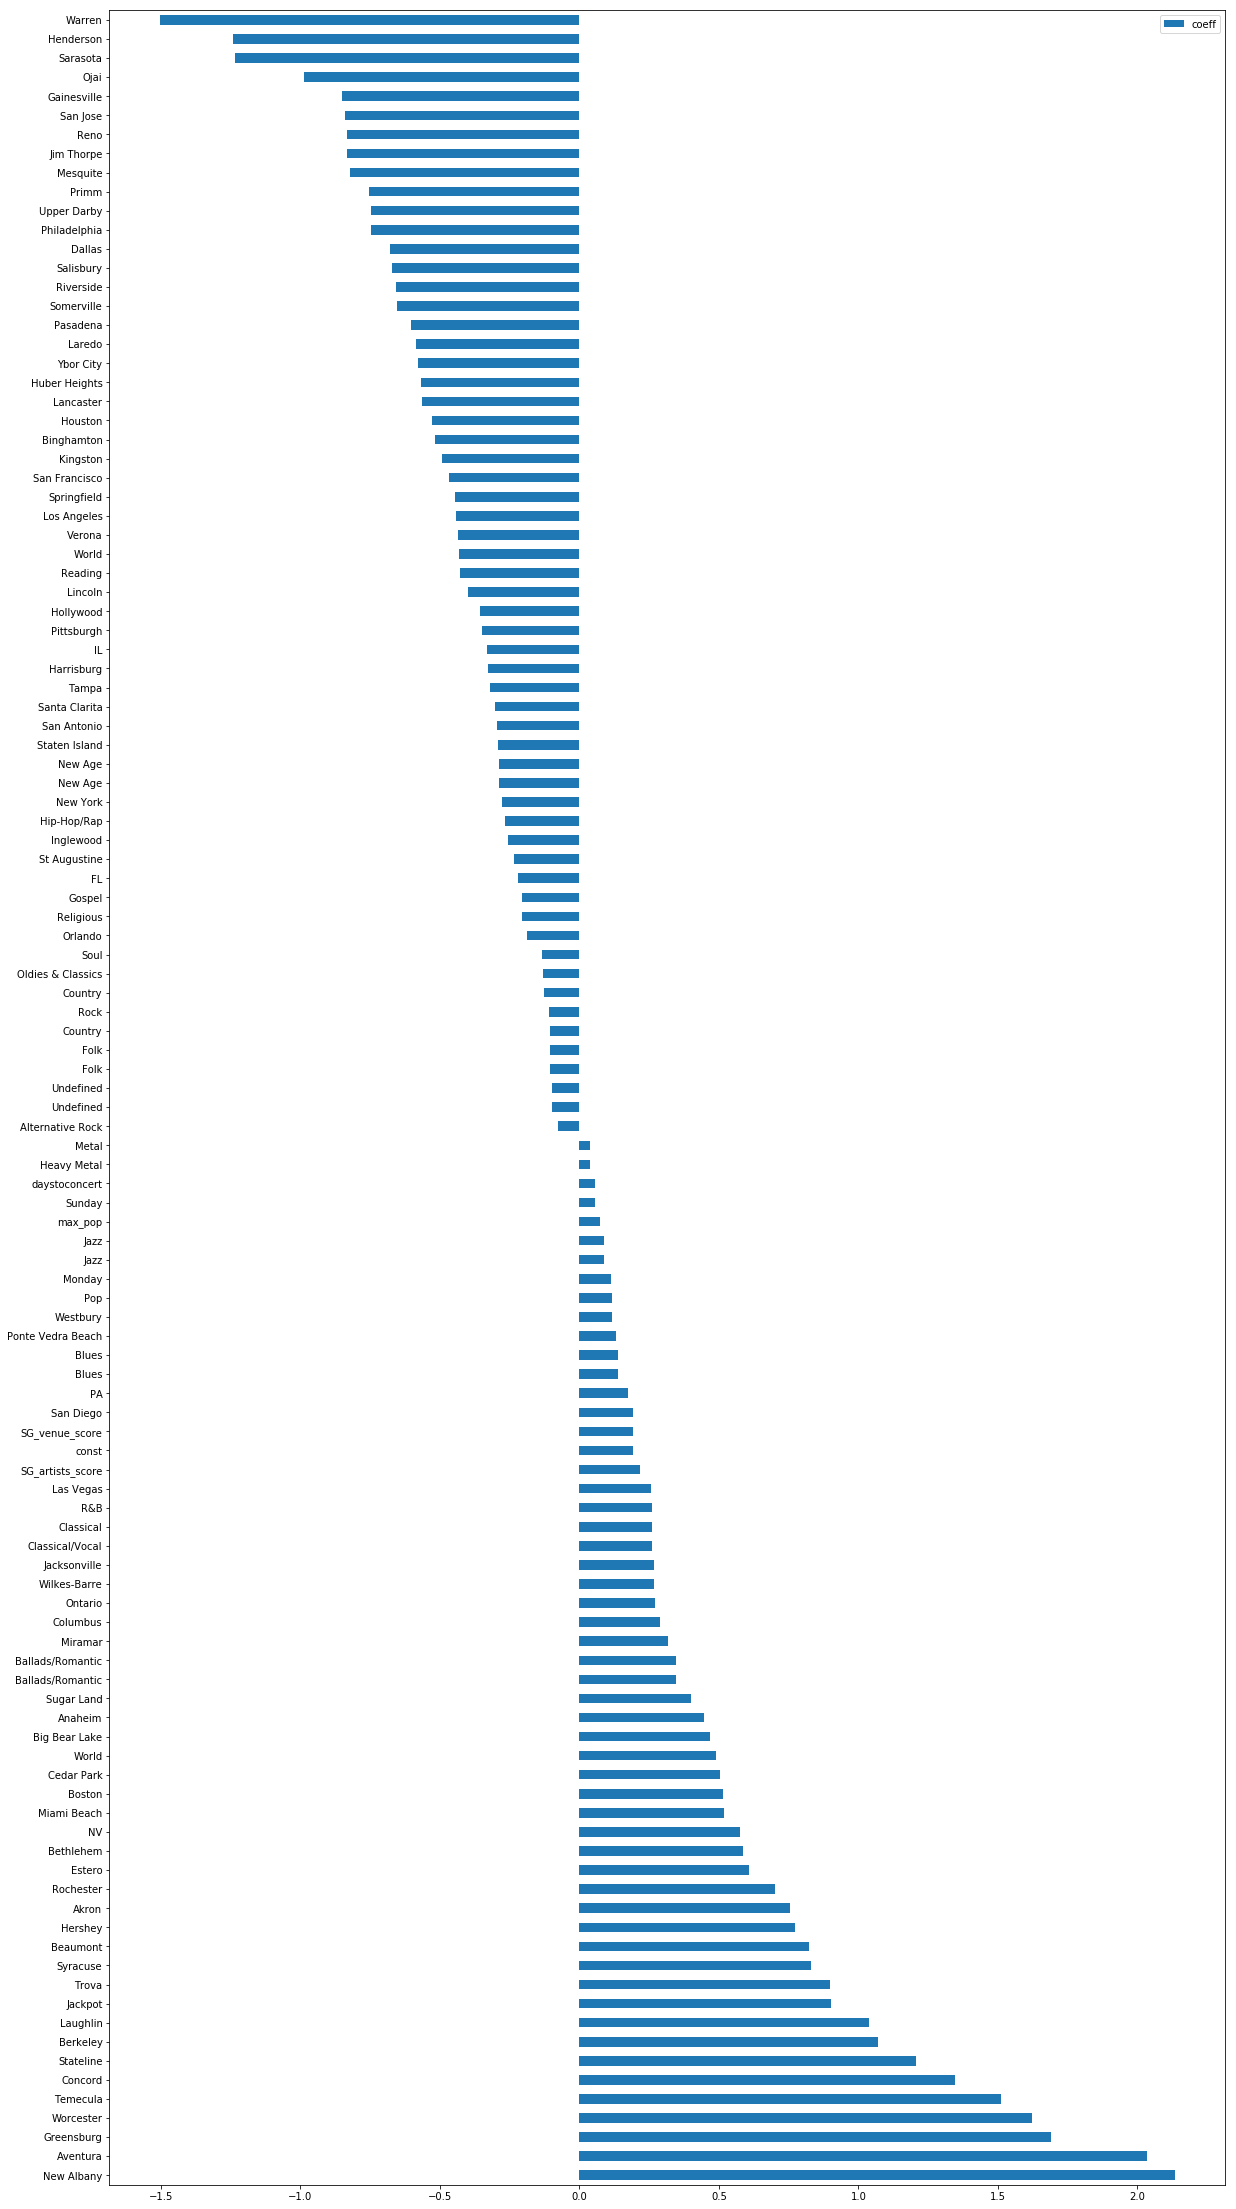

In [0]:
#Remove Promoters
mainVars = results2.iloc[:5, :]
tailVars = results2.iloc[-109:, :]
combine = [mainVars,tailVars]
final = pd.concat(combine)




#Sort by coefficient
final = final.sort_values(by='coeff', ascending=False)


#Plot with all significant variables
final.plot.barh(y='coeff', rot=0, figsize=(20,40))

#Plot removing coefficient close to 0 to get only the most impactful variables





## **Continous variable Standardization - MinMax scaler**

In [0]:
#Re-build X and Y

X = df[['SG_artists_score',
'venue_city',
'SG_venue_score',
'venue_state',
'max_pop',
'max_follow',
'daystoconcert',
        "genre",
       "weekday"]]

#Target
#Output is Type pandas df
Y = df[['SG_average_price']].astype(int)



#one Hot
dummies1 = pd.get_dummies(df['promoter'])
X= pd.concat([X,dummies1],axis=1)

dummies2 = pd.get_dummies(df['genre'])
X= pd.concat([X,dummies2],axis=1)

dummies3 = pd.get_dummies(df['subGenre'])
X= pd.concat([X,dummies3],axis=1)

dummies4 = pd.get_dummies(df['venue_city'])
X= pd.concat([X,dummies4],axis=1)

dummies5 = pd.get_dummies(df['venue_state'])
X= pd.concat([X,dummies5],axis=1)

dummies6 = pd.get_dummies(df['weekday'])
X= pd.concat([X,dummies6],axis=1)

X.drop(columns=['genre','venue_city','venue_state','weekday' ], inplace=True)



In [0]:
#min-max Scaler! 

from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X[['daystoconcert', 'SG_artists_score','SG_venue_score','max_pop','max_follow','daystoconcert']] = mms.fit_transform(X[['daystoconcert', 'SG_artists_score','SG_venue_score','max_pop','max_follow','daystoconcert']])
Y[['SG_average_price']] = mms.fit_transform(Y[['SG_average_price']])

Y.describe()
X.describe()












/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,SG_artists_score,SG_venue_score,max_pop,max_follow,daystoconcert,191 TOURING,AEG - TICKETING,AEG LIVE,AL WASH,ANDREW HEWITT & BILL SILVA PRESENTS,...,PA,TN,TX,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,...,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000,11861.000000
mean,0.352686,0.422736,0.560105,0.038971,0.382412,0.000084,0.000253,0.010539,0.000084,0.001096,...,0.139111,0.003963,0.019223,0.249136,0.032375,0.266335,0.077818,0.180845,0.083635,0.109856
std,0.122981,0.176451,0.162055,0.089593,0.226343,0.009182,0.015902,0.102120,0.009182,0.033090,...,0.346077,0.062827,0.137313,0.432531,0.177001,0.442060,0.267896,0.384906,0.276852,0.312723
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.267857,0.287441,0.476744,0.003404,0.191176,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.339286,0.403503,0.593023,0.013332,0.360294,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.410714,0.518843,0.662791,0.039308,0.551471,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Check for multicollinearity - via Correlation**

## Spliting data into test and train


In [0]:
##Import function for splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2,random_state=1)

In [0]:
print ("X.shape:", X.shape)
print ("Y.shape:", Y.shape)
print ("X_train.shape:", X_train.shape)
print ("X_test.shape:", X_test.shape)
print ("y_train.shape:", y_train.shape)
print ("y_test.shape:", y_test.shape)

X.shape: (11861, 230)
Y.shape: (11861, 1)
X_train.shape: (9488, 230)
X_test.shape: (2373, 230)
y_train.shape: (9488, 1)
y_test.shape: (2373, 1)


##Fitting, training and predicting models.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


In [0]:
#Getting P-value
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:       SG_average_price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     79.00
Date:                Tue, 23 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:55:43   Log-Likelihood:                 7890.5
No. Observations:               11861   AIC:                        -1.539e+04
Df Residuals:                   11666   BIC:                        -1.395e+04
Df Model:                         194                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [0]:
# take the result of an statsmodel results table and transforms it into a dataframe

def results_summary_to_dataframe(results):
   
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df
  
#Build dataframe with Coefficients 
result = results_summary_to_dataframe(est2)

#remove insignificant p values
results2 = result[result['pvals'] < 0.05]
results2




,coeff,pvals,conf_lower,conf_higher
const,0.125650,2.562194e-31,0.104554,0.146747
SG_artists_score,0.334718,1.885532e-118,0.306689,0.362748
SG_venue_score,0.206170,1.411803e-50,0.179280,0.233060
max_pop,0.084688,5.190292e-15,0.063494,0.105881
daystoconcert,0.048252,1.667492e-17,0.037162,0.059343
AEG - TICKETING,0.398714,2.688420e-08,0.258259,0.539168
ANDREW HEWITT & BILL SILVA PRESENTS,0.080244,3.694369e-02,0.004863,0.155625
ANOTHER PLANET,-0.111534,1.291616e-10,-0.145514,-0.077555
BRE PRESENTS,-0.060467,2.298905e-03,-0.099337,-0.021597
BROADWAY IN CHICAGO,0.266318,1.290060e-10,0.185184,0.347452


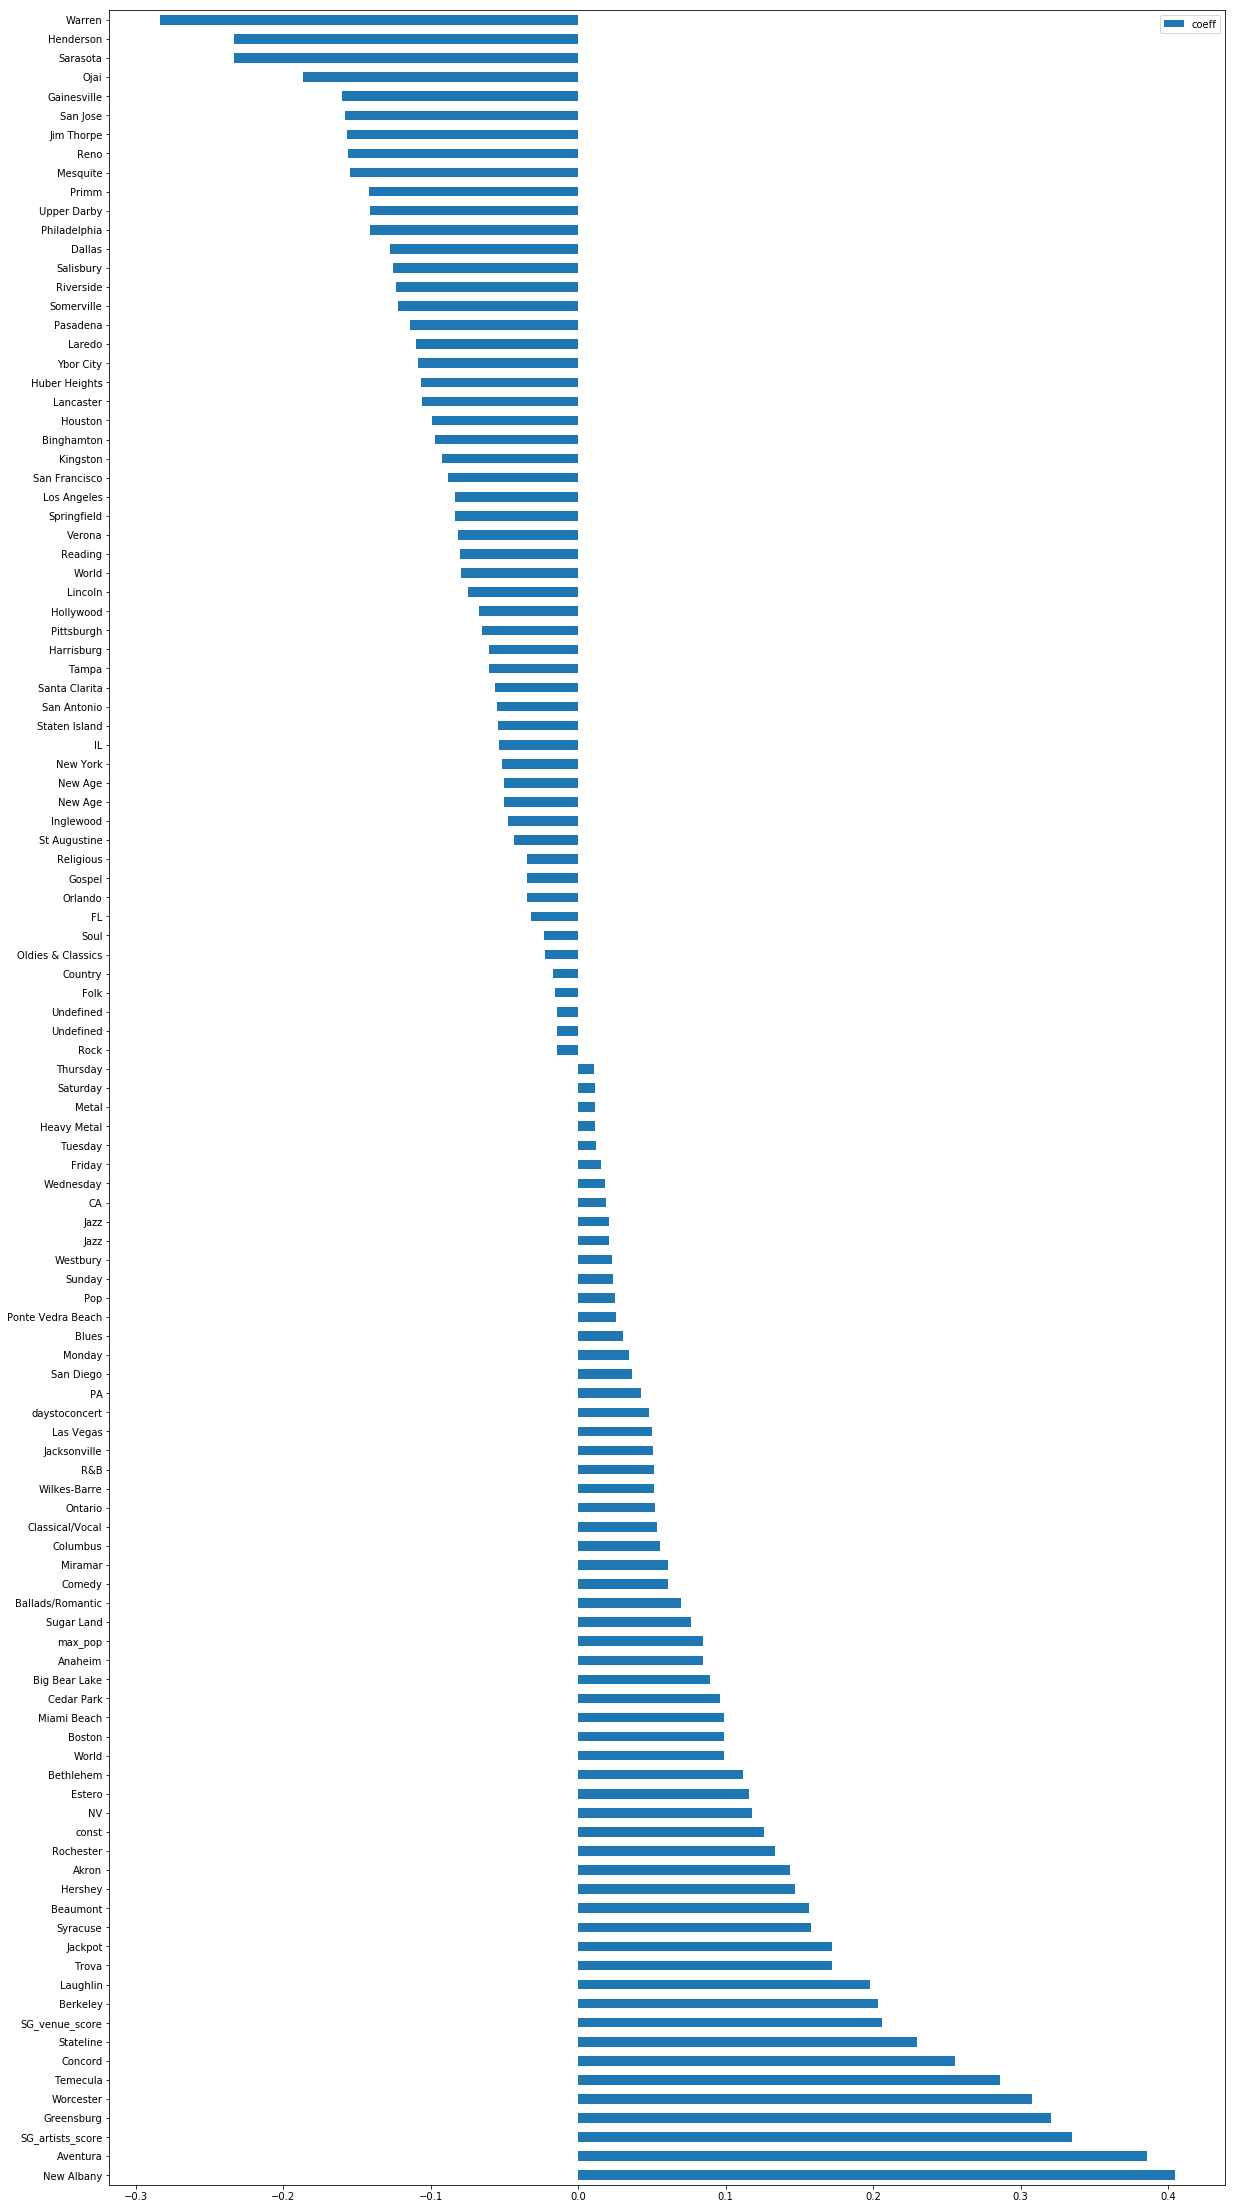

In [0]:
#Remove Promoters
mainVars = results2.iloc[:5, :]
tailVars = results2.iloc[-109:, :]
combine = [mainVars,tailVars]
final = pd.concat(combine)




#Sort by coefficient
final = final.sort_values(by='coeff', ascending=False)


#Plot with all significant variables
final.plot.barh(y='coeff', rot=0, figsize=(20,40))

#Plot removing coefficient close to 0 to get only the most impactful variables



